# Import Packages

In [29]:
import os
import random
import cv2
import random
from PIL import Image
import tifffile as tiff
import models_pytorch
import losses_pytorch
import imageio as io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import defaultdict 


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from skimage.morphology import binary_dilation, binary_erosion
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import average_precision_score
import segmentation_models_pytorch as smp

import albumentations as A
import albumentations.augmentations.functional as FA
from albumentations.pytorch import ToTensorV2

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Losses

In [31]:
def weighted_bce_loss(output,y,weight):
    epsilon= 1e-7
    output = torch.clamp(output, epsilon, 1.-epsilon)
    logit_output = torch.log(output/(1.-output))
    
    loss = (1.-y)*logit_output + (1.+(weight-1.)*y) * (torch.log(1.+torch.exp(-torch.abs(logit_output))) + torch.maximum(-logit_output,torch.tensor(0.).cuda()))
    return torch.sum(loss)/torch.sum(weight)

def weighted_dice_loss(output,y,weight):
    smooth = 1.
    w,m1,m2 = weight*weight, y, output
    intersection = (m1*m2)
    score = (2.*torch.sum(w*intersection)+smooth)/(torch.sum(w*m1)+torch.sum(w*m2)+smooth)
    loss  = 1.-torch.sum(score)
    return loss

def iou_loss(y_pred, y_true, weight):
    weight = weight*weight
    intersection = y_true * y_pred
    not_true     = 1 - y_true
    union        = y_true + (not_true * y_pred)
    iou          = (torch.sum(intersection * weight)) / (torch.sum(union * weight))

    loss = 1-iou
    return loss
    

def border_loss(output,y,pool_size=(9,9), pad=(4,4)):
    y      = y.type(torch.float32)
    
    output = output.type(torch.float32)
    
    averaged_mask = F.avg_pool2d(y,kernel_size=pool_size,stride=(1,1), padding=pad)
    border = (averaged_mask>0.005).type(torch.float32) * (averaged_mask<0.995).type(torch.float32)
    weight = torch.ones_like(averaged_mask)
    w0     = torch.sum(weight)
    weight+= border*2
    w1     = torch.sum(weight)
    weight*= (w0/w1)
    loss   = weighted_bce_loss(output,y,weight) + weighted_dice_loss(output,y,weight) + iou_loss(output,y,weight)
    return loss

# Functions

In [32]:
################ Metrics #######################
def IoU_pr_rec_f1(y_true, y_pred):
    
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    y_pred = ((y_pred)*1.).type(torch.float32)
    
    tp = torch.sum(y_true*(y_pred))
    tn = torch.sum((1-y_true)*((1-y_pred)))
    fp = torch.sum((1-y_true)*(y_pred))
    fn = torch.sum((y_true)*((1-y_pred)))
    
    pr  = (tp/(tp+fp))
    rec = (tp/(tp+fn))
    f1  = ((2*pr*rec)/(pr+rec))
    tnr = (tn/(tn+fp))
    fpr = (fp/(fp+tn))
    
    intersection = y_true*y_pred
    not_true     = 1 - y_true
    union        = y_true + (not_true * y_pred)
    iou         = (torch.sum(intersection)) / (torch.sum(union))
    
    return iou, pr, rec, f1, tnr, fpr

# Saving Metrics
def metrics():
    x = np.arange(0,1,0.05)
    IoU_      = []
    threshold = []
    precision = []
    recall    = []
    F_score   = []
    mF_score  = []
    TNR       = []
    FPR       = []
    name_list = []

    dict_1 = {'Name':name_list,
              'Precision':precision,
              'Recall':recall,
              'IoU':IoU_,
              'F-Score':F_score,
              'mF-Score':mF_score,
              'Threshold': threshold,
              'True Negative Rate':TNR,
              'False Positive Rate':FPR}
    return dict_1

def best_f_score(name, test_masks, predictions) :
    dict_1 = metrics()
    y = 0
    outer = 0
    check = 0
    x = 0 
    y = 1
    while outer<3:    
        if y>1:
            m = y-1
            y-= m
        z = np.linspace(x, y, 21)
        for i in z:
#             print(i)
            y_true = torch.from_numpy(test_masks)
            y_pred = torch.from_numpy((predictions>i)*1)

            tp = torch.sum(y_true*(y_pred),dim=[1,2,3])
            tn = torch.sum((1-y_true)*((1-y_pred)),dim=[1,2,3])
            fp = torch.sum((1-y_true)*(y_pred),dim=[1,2,3])
            fn = torch.sum((y_true)*((1-y_pred)),dim=[1,2,3])

            pr  = (tp/(tp+fp))
            rec = (tp/(tp+fn))
            score  = ((2*pr*rec)/(pr+rec))
            idx    = torch.isnan(score)
            score[idx] = 0
            score  = torch.sum(score)/len(X_test)
            
            a,b,c,d,e,f = IoU_pr_rec_f1(torch.from_numpy(test_masks), torch.from_numpy(predictions>i))
            dict_1['IoU'].append(a.numpy())
            dict_1['Threshold'].append(i)
            dict_1['Precision'].append(b.numpy())
            dict_1['Recall'].append(c.numpy())
            dict_1['F-Score'].append(d.numpy())
            dict_1['mF-Score'].append(score.cpu().detach().numpy())
            dict_1['True Negative Rate'].append(e.numpy())
            dict_1['False Positive Rate'].append(f.numpy())
            dict_1['Name'].append(name)
            if d>check:
                check = d
                x = i
            else:
                pass
        if outer == 0:
            y = x+0.1
        elif outer==1:
            y = x+0.01
        outer+=1
    
    df = pd.DataFrame(dict_1)
    df = df.sort_values(by=['F-Score'], ascending=False)
    df = df.iloc[0:1]
    
    AP = average_precision_score(test_masks.reshape(-1), predictions.reshape(-1))
    df['AP'] = AP
        
    return df

dict_1 = metrics()

In [33]:
################ Metadata ########################
def metadata(Y):
    list_ = defaultdict(list)
    for i in range(len(Y)):
        water = (Y[i].sum()/np.prod(Y[i].shape))*100
        list_[f'Image_{i}'].append(water)
        list_[f'Image_{i}'].append(100-water)
    for i in range(len(Y)):
        water = (Y[i].sum()/np.prod(Y[i].shape))*100
        if water>90:
            list_[f'Image_{i}'].append(1)
        else:
            list_[f'Image_{i}'].append(0)
    for i in range(len(Y)):
        water = (Y[i].sum()/np.prod(Y[i].shape))*100
        if water<10:
            list_[f'Image_{i}'].append(1)
        else:
            list_[f'Image_{i}'].append(0)
    return list_

def water_percentages(df_meta):
    water_p = df_meta[0].values
    indices = np.arange(len(water_p))
    dict_idx = {}
    limit = 10
    for i in range(12):
        if i==0:
            idx = np.where(water_p==0)
            dict_idx[f'Index=0'] = indices[idx[0]]
            water_p = np.delete(water_p, idx)
            indices = np.delete(indices, idx)
        elif i==11:
            idx = np.where(water_p==100)
            dict_idx[f'Index=100'] = indices[idx[0]]
            water_p = np.delete(water_p, idx)
            indices = np.delete(indices, idx)
        else:
            idx = np.where(water_p<limit)
            dict_idx[f'Index_{limit}'] = indices[idx[0]]
            water_p = np.delete(water_p, idx)
            indices = np.delete(indices, idx)
            limit+=10
            
    return dict_idx

def list_test(dict_idx):
    counter = 0
    list_ = []
    dict_ ={}
    lower = 0
    upper = 10
    for key in dict_idx.keys():

        print(f'{key}:',len(dict_idx[key]))
        counter+=len(dict_idx[key])
        dict_['Water'+key.split('Index')[-1]] = [len(dict_idx[key]), len(dict_idx[key])/2053*100]
        list_.append(list(dict_idx[key]))
        lower+=10
        upper+=10
    print(f'Total Images: {counter}')
    print('-'*10)
    print()
    
    
    return list_

In [34]:
############## F1 for Train Time Display 0.5 Threshold ##################
def f1_score(y_pred, y_true, threshold=0.5):
    
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)
    y_pred = ((y_pred>threshold)*1.).type(torch.float32)
    
    tp = torch.sum(y_true*(y_pred))
    tn = torch.sum((1-y_true)*((1-y_pred)))
    fp = torch.sum((1-y_true)*(y_pred))
    fn = torch.sum((y_true)*((1-y_pred)))
    
    pr  = ((tp+1.)/(tp+fp+1.))
    rec = ((tp+1.)/(tp+fn+1.))
    f1  = ((2*pr*rec)/(pr+rec))
    return f1

# Load Data

In [35]:
X_train = np.load(r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_train_4500_30m_res.npy")
X_val   = np.load(r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_val_500_30m_res.npy")
X_test  = np.load(r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Data\Landsat 30m Resolution\X_test_2000_30m_res.npy")

Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
Y_val           = (X_val[...,1]-X_val[...,3])/(X_val[...,1]+X_val[...,3])
Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])

Y_train         = ((Y_train<1.)*1).astype('float32')
Y_val           = ((Y_val<1.)*1).astype('float32')
Y_test          = ((Y_test<1.)*1).astype('float32')

X_train         = X_train[...,2::-1].copy()
X_val           = X_val[...,2::-1].copy()
X_test          = X_test[...,2::-1].copy()

X_train         = X_train - X_train.min(axis=(1,2), keepdims=True) 
X_val           = X_val  - X_val.min(axis=(1,2), keepdims=True)
X_test          = X_test - X_test.min(axis=(1,2), keepdims=True) 

X_train         = X_train / X_train.max(axis=(1,2), keepdims=True) 
X_val           = X_val  / X_val.max(axis=(1,2), keepdims=True)
X_test          = X_test / X_test.max(axis=(1,2), keepdims=True) 

C:\Users\HPCL\AppData\Local\Temp/ipykernel_11692/789549544.py:5: RuntimeWarning: invalid value encountered in true_divide
  Y_train         = (X_train[...,1]-X_train[...,3])/(X_train[...,1]+X_train[...,3])
C:\Users\HPCL\AppData\Local\Temp/ipykernel_11692/789549544.py:7: RuntimeWarning: invalid value encountered in true_divide
  Y_test          = (X_test[...,1]-X_test[...,3])/(X_test[...,1]+X_test[...,3])


In [36]:
#Get Metadata Sentinel
df = metadata(Y_train)
df_meta_train = pd.DataFrame.from_dict(df,orient='index')
print('Test Images:',len(df_meta_train))

#Get Metadata Landsat
df = metadata(Y_test)
df_meta_test = pd.DataFrame.from_dict(df,orient='index')
print('Test Images:',len(df_meta_test))

Test Images: 4500
Test Images: 2000


In [37]:
water_p_train = water_percentages(df_meta_train)
water_p_test = water_percentages(df_meta_test)

list_test_train = list_test(water_p_train)
list_test_test = list_test(water_p_test)

Index=0: 0
Index_10: 138
Index_20: 509
Index_30: 450
Index_40: 414
Index_50: 304
Index_60: 381
Index_70: 365
Index_80: 379
Index_90: 483
Index_100: 1077
Index=100: 0
Total Images: 4500
----------

Index=0: 0
Index_10: 59
Index_20: 215
Index_30: 204
Index_40: 185
Index_50: 149
Index_60: 173
Index_70: 181
Index_80: 155
Index_90: 199
Index_100: 480
Index=100: 0
Total Images: 2000
----------



In [38]:
################ Get Contours ##########################
Y_train = np.array([binary_dilation(mask)-mask for mask in Y_train ], dtype='float64')
Y_val   = np.array([binary_dilation(mask)-mask for mask in Y_val], dtype='float64')
Y_test  = np.array([binary_dilation(mask)-mask for mask in Y_test], dtype='float64')

# Pytorch DataLoaders

In [39]:
class NDWIDataset(Dataset):

    def __init__(self, images, masks, transform=None, test_transform=None):
        self.images     = images
        self.masks      = masks
        self.transforms = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transforms:
            augmentations = self.transforms(image=image, mask=mask)
        
        image = augmentations['image']
        mask  = augmentations['mask']
        mask  = mask[np.newaxis,:,:]
        
        return [image.type(torch.float32), 
                mask.type(torch.float32)]
        

In [40]:
def data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test, split=0.9, val=True, batch_size=16):
    torch.manual_seed(49)
    random.seed(49)
    trainset= NDWIDataset(X_train, Y_train, transform=trans)

    if val:
        print(f'Training:{len(X_train)}, Validation:{len(X_val)}')
        print(f'Testing: {len(X_test)}')
        
        valset  = NDWIDataset(X_val, Y_val, transform=trans_test)
        testset = NDWIDataset(X_test, Y_test, transform=trans_test)
        image_datasets = {'train': trainset, 'val': valset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True, drop_last=True),#, num_workers=8),
          'val': DataLoader(valset, batch_size=batch_size, shuffle=True, pin_memory = True, drop_last=True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True, drop_last=True)#, num_workers=8)
        }
        
    else:
        print(f'Training:{len(X_train)}')
        print(f'Testing: {len(X_test)}')
        testset = NDWIDataset(X_test, Y_test, transform=trans_test)
        image_datasets = {'train': trainset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True)#, num_workers=8)
        }
        
    
    return dataloaders

In [41]:
trans = A.Compose([
    ToTensorV2()])
trans_test = A.Compose([
             ToTensorV2()])

In [42]:
def plot_rand(dataloader, set_='train'):
    if set_==None:
        for x,y in dataloader:
            x,y = x.numpy().transpose([0,2,3,1]), y.numpy().squeeze()
            break
    else:
        for x,y in dataloader[set_]:
            x,y = x.numpy().transpose([0,2,3,1]), y.numpy().squeeze()
            break
    rand = np.random.randint(0,x.shape[0])
    plt.subplot(121)
    plt.imshow(x[rand])
    plt.title('Image')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(y[rand])
    plt.title('Contour')
    plt.axis('off')
    plt.show()

In [43]:
dataloaders = data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test)

Training:4500, Validation:500
Testing: 2000


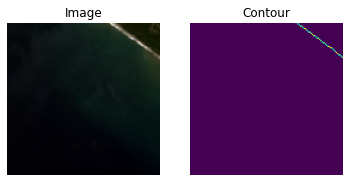

In [44]:
plot_rand(dataloaders)

# Train Function

In [45]:
import time
def train(model, dataloaders, loss_fn, optimizer, acc_fn, random_state=49, epochs=1):
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.backends.cudnn.benchmark = True
    torch.use_deterministic_algorithms(False)
    start = time.time()                                        #Initialize time to calculate time it takes to train model
    model.to(device)                                               #Move model to GPU     

    counter=0
    train_loss, valid_loss = [], []                            #Running training and validation loss
    val_epoch, f1_epoch = [0],[0]
    loss_list = []
    times     = []
#     epoch = 1
    for epoch in range(epochs):
        start_epoch = time.time()
        print(f'Epoch {epoch+1}')
        print(scheduler.get_last_lr())
    

    #########################################Begin Model Training######################################################
    ###################################################################################################################
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()                             # Set training mode all the layers including batchnorm and dropout work in this
                dataloader = dataloaders['train']         #get the training data
            else:
                model.eval()                              # Set model to evaluate mode deactivates the batchnorm and dropout layers
                dataloader = dataloaders['val']           #get the validation data

            running_loss = 0.0                            #running loss to be used for visualization later
            step = 0                                      #Batch number
            
            if phase == 'train':  
                f1 = []
                for inputs, labels in dataloader:
                    x, y = inputs.to(device), labels.to(device)
                    step += 1

                    optimizer.zero_grad()                                   # zero the gradients
                    outputs = model(x)                                      #get model output for a given input

                    #################Metrics###################
                    f1.append(acc_fn(outputs, y).cpu().detach().numpy())
                    ############################################

                    ##################Calculate Loss, backprop, and update###############
                    loss           = loss_fn(outputs, y)
                    train_loss.append(loss.cpu().detach().numpy())
                    loss.backward()
                    optimizer.step()
                    print(f'Current step: {step}, AllocMem (Mb): {torch.cuda.memory_allocated()/1024/1024:.3f}, Loss: {loss:.3f},  F1: {np.mean(f1):.3f}', end='\r') 
                    ######################################################################
        
            else:  
                loss_val = []
                f1=[]
                with torch.no_grad():
                    for inputs, labels in dataloader:
                        x, y = inputs.to(device), labels.to(device)
                        optimizer.zero_grad()                                   # zero the gradients
                        outputs = model(x)                                      #get model output for a given input

                        #################Metrics###################
                        f1.append(acc_fn(outputs, y).cpu().detach().numpy())
                        ############################################

                        ##################Calculate Loss, backprop, and update###############
                        valid_loss.append(loss_fn(outputs, y).cpu().detach().numpy())
                        loss_val.append(valid_loss[-1])
                val_epoch.append(np.mean(loss_val))
                f1_epoch.append(np.mean(f1))
                print()
                print()
                print(f' Loss val: {val_epoch[-1]:.3f}, F-Score val:{f1_epoch[-1]:.3f} \n') 
                ######################################################################
                
                ##### Check validation #####
#                 if f1_epoch[-1] > f1_epoch[-2]:
#                     counter = 0
#                     print('Counter Reset')
#                 else:
#                     counter+=1
#                     print(f'Counter is {counter}')

            print()
            time_elapsed = time.time() - start_epoch
            times.append(time_elapsed)
            print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
            print('-' * 10)      

        scheduler.step()
#         torch.save(model, path+ '\\' + f'Epcoh_{str(epoch).zfill(3)}'+ '.pth')
        epoch+=1
    #########################################End Model Training######################################################
    ###################################################################################################################
    
    #Total training time including time to test
    time_elapsed = time.time() - start
    print('\n Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return {'Train Loss':train_loss,
            'Valid Loss':valid_loss,
            'Times'     :times,
            'Epochs'    : epoch+1}

## Prediction Function

In [46]:
def test_pred(model,X_test,batch_size=32):
    model.eval()
    if model.training==True:
        raise ValueError('Model is in training mode')
    else:
        pass
    
    predictions = np.zeros([len(X_test),1,X_test.shape[1],X_test.shape[2]])
    i = 0
    for x, y in tqdm(dataloaders['test']):
        predictions[i:i+batch_size] = model(x.cuda()).cpu().detach().numpy()
        i+=batch_size
    return predictions




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































# Experiments

In [47]:
model_dir = r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Results\Landsat\Final Models\2dil-ndwi"
csv_dir   = r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Results\Landsat\Final Models\2dil-ndwi\F-scores.csv"
dataset = 'Landsat'

### RGB

In [48]:
trans = A.Compose([
    ToTensorV2()])
trans_test = A.Compose([
                ToTensorV2()])

batch_size = 32
dataloaders = data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test, batch_size=batch_size)

Training:4500, Validation:500
Testing: 2000


In [49]:
name = 'PAN'
loss_name = 'BCE+IoU+Dice, 9x9 Border'


model = smp.PAN(encoder_name='resnet34', encoder_weights=None, activation='sigmoid').to(device)
opt = optim.Adam(model.parameters(), lr=0.003)
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[100,180], gamma=0.1)
history = train(model, dataloaders, loss_fn = border_loss, optimizer = opt, acc_fn = f1_score, epochs=50)

Epoch 1
[0.003]
Current step: 140, AllocMem (Mb): 343.148, Loss: 1.787,  F1: 0.182
Training complete in 0m 14s
----------


 Loss val: 1.899, F-Score val:0.103 


Training complete in 0m 15s
----------
Epoch 2
[0.003]
Current step: 140, AllocMem (Mb): 342.648, Loss: 1.633,  F1: 0.250
Training complete in 0m 7s
----------


 Loss val: 1.722, F-Score val:0.244 


Training complete in 0m 7s
----------
Epoch 3
[0.003]
Current step: 140, AllocMem (Mb): 343.148, Loss: 1.624,  F1: 0.288
Training complete in 0m 7s
----------


 Loss val: 1.728, F-Score val:0.261 


Training complete in 0m 7s
----------
Epoch 4
[0.003]
Current step: 140, AllocMem (Mb): 342.648, Loss: 1.615,  F1: 0.311
Training complete in 0m 7s
----------


 Loss val: 1.710, F-Score val:0.274 


Training complete in 0m 7s
----------
Epoch 5
[0.003]
Current step: 140, AllocMem (Mb): 343.148, Loss: 1.562,  F1: 0.318
Training complete in 0m 7s
----------


 Loss val: 1.591, F-Score val:0.316 


Training complete in 0m 7s
---------

Current step: 140, AllocMem (Mb): 342.648, Loss: 1.301,  F1: 0.464
Training complete in 0m 7s
----------


 Loss val: 1.399, F-Score val:0.429 


Training complete in 0m 7s
----------
Epoch 43
[0.003]
Current step: 140, AllocMem (Mb): 343.148, Loss: 1.355,  F1: 0.461
Training complete in 0m 7s
----------


 Loss val: 1.435, F-Score val:0.415 


Training complete in 0m 7s
----------
Epoch 44
[0.003]
Current step: 140, AllocMem (Mb): 342.648, Loss: 1.417,  F1: 0.460
Training complete in 0m 7s
----------


 Loss val: 1.408, F-Score val:0.422 


Training complete in 0m 7s
----------
Epoch 45
[0.003]
Current step: 140, AllocMem (Mb): 343.148, Loss: 1.370,  F1: 0.467
Training complete in 0m 7s
----------


 Loss val: 1.398, F-Score val:0.431 


Training complete in 0m 7s
----------
Epoch 46
[0.003]
Current step: 140, AllocMem (Mb): 342.648, Loss: 1.352,  F1: 0.470
Training complete in 0m 7s
----------


 Loss val: 1.403, F-Score val:0.430 


Training complete in 0m 7s
----------
Epoch 47
[0.

In [50]:
############### F-score and Save Model #################
predictions = test_pred(model, X_test, batch_size=32)
df = best_f_score(name, Y_test[:,np.newaxis,:,:], predictions)
df['Time'] = round(np.mean(history['Times']),2)
df.to_csv(csv_dir, mode='a')
torch.save({'Dataset'   : f'{dataset}_5K_2K_30m {name}',
            'Batch Size': batch_size,
            'Loss'      : loss_name,
            'Model'     : model,
            'F-score'   : df['F-Score'].values[0],
            'Time'      : round(np.mean(history['Times']),2),
            'Train Loss': history['Train Loss'],
            'Validation Loss': history['Valid Loss'],
            'Epochs'    : history['Epochs']},
          model_dir + '\\' + name +'.pth')
df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 48.53it/s]


,Name,Precision,Recall,IoU,F-Score,mF-Score,Threshold,True Negative Rate,False Positive Rate,AP,Time
49,PAN,0.32975633523999587,0.6434712061259927,0.27881455862327564,0.4360515865935043,0.4275104147461696,0.5035,0.9858268775579014,0.014173122442098535,0.326094,6.96


In [51]:
################### F-score By Group ################
path = csv_dir.replace('F-scores.csv', 'F-scores_group.csv')
dict_f1 = {}
for key, list_ in zip(water_p_test.keys(),list_test_test):
    y_true= torch.from_numpy(Y_test[:,np.newaxis,:,:][list_])
    y_pred= torch.from_numpy(predictions[list_])
    dict_f1['Water'+key.split('Index')[-1]] = f1_score(y_pred.reshape(-1), y_true.reshape(-1), threshold=df['Threshold'].values[0])


df_f1 = pd.DataFrame.from_dict(dict_f1, orient='index')
df_f1 = pd.DataFrame(df_f1[0].rename('F1_score'))
df_f1 = df_f1.append(pd.Series(), ignore_index=True)
df_f1.index.names = [name]
df_f1.to_csv(path, mode='a')

C:\Users\HPCL\AppData\Local\Temp/ipykernel_11692/2657704787.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_f1 = df_f1.append(pd.Series(), ignore_index=True)
